In [1]:
from collections import OrderedDict
import warnings

import flwr as fl
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec220.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:1000000]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug3-1.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:1000000]

aggregate_df1 = aggregate_df1.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

mask = [i % 5 != 0 for i in range(len(aggregate_df1))]
X_test = aggregate_df1[~np.array(mask)]
X_train = aggregate_df1[mask]



mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_test = plug1_1[~np.array(mask1)]
y_train = plug1_1[mask1]


X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train, length=100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test, length=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

    
class sgn_branch_network(nn.Module):
    def __init__(self, mains_length, appliance_length):
        super(sgn_branch_network, self).__init__()
        self.mains_length = mains_length
        self.appliance_length = appliance_length
        
        self.conv = nn.Sequential(
            nn.ConstantPad1d((4, 5), 0),
            nn.Conv1d(100, 30, 10, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((3, 4), 0),
            nn.Conv1d(30, 30, 8, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 3), 0),
            nn.Conv1d(30, 40, 6, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 2), 0),
            nn.Conv1d(40, 50, 5, stride = 1),
            nn.ReLU(True),
            nn.ConstantPad1d((2, 2), 0),
            nn.Conv1d(50, 50, 5, stride = 1),
            nn.ReLU(True)
        )
        self.dense = nn.Sequential(
            nn.Linear(50 , 1024),
            nn.ReLU(True),
            nn.Linear(1024, 100)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.dense(x.view(x.size(0), -1))
        return x


class sgn_Pytorch(nn.Module):
    def __init__(self, mains_length, appliance_length):
        # Refer to "SHIN C, JOO S, YIM J. Subtask Gated Networks for Non-Intrusive Load Monitoring[J]. Proceedings of the AAAI Conference on Artificial Intelligence."
        super(sgn_Pytorch, self).__init__()
        self.gate = sgn_branch_network(mains_length, appliance_length)
        self.reg = sgn_branch_network(mains_length, appliance_length)
        self.act = nn.Sigmoid()
        self.b = nn.parameter.Parameter(torch.zeros(1))

    def forward(self, x):
        reg_power = self.reg(x)
        app_state = self.act(self.gate(x))
        app_power = reg_power * app_state + (1 - app_state) * self.b
        return app_power, app_state

n_input = 100
model = sgn_Pytorch(60, n_input)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
mae_fn = nn.L1Loss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = loss_fn.to(device)
mae_fn = mae_fn.to(device)

from torch.nn import L1Loss
import matplotlib.pyplot as plt
import tqdm



def rete(y_true, y_pred):
    y_true = y_true.view(-1, 1)
    y_pred = y_pred.view(-1, 1)

    # Compute the maximum value between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    max_val, _ = torch.max(torch.cat([y_pred, y_true], dim=1), dim=1, keepdim=True)

    # Compute the relative error between y_true and y_pred element-wise, and reshape it to have shape (batch_size*seq_len, 1)
    rel_err = torch.abs(y_pred - y_true) / max_val

    # Take the mean of the relative error across all samples in the batch
    return torch.mean(rel_err)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = loss_fn.to(device)
mae_fn = mae_fn.to(device)


def train(net, trainloader, epochs):
    for epoch in range(epochs):
        for i, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_loader)):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred1, y_pred2 = model(X_batch) 
            batch_size, sequence_length, output_size = y_batch.shape
            y_batch = y_batch.reshape(batch_size * sequence_length, output_size)
            y_pred1 = y_pred1.reshape(batch_size * sequence_length, 1)
            loss = loss_fn(y_pred1, y_batch)
            mae = mae_fn(y_pred1, y_batch)
            rete_val = rete(y_batch[:, 0], y_pred1.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tqdm.tqdm.write(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item()}, MAE: {mae.item()}, Rete: {rete_val.item()}")
        
def test(net, testloader):
    with torch.no_grad():
        for X_batch, y_batch in testloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred1, y_pred2 = model(X_batch) 
            batch_size, sequence_length, output_size = y_batch.shape
            y_batch = y_batch.reshape(batch_size * sequence_length, output_size)
            y_pred1 = y_pred1.reshape(batch_size * sequence_length, 1)
            loss = loss_fn(y_pred1, y_batch)
            mae = mae_fn(y_pred1, y_batch)
            rete_val = rete(y_batch[:, 0], y_pred1.view(-1))
        print(f" Loss: {loss.item()}, MAE: {mae.item()}, Rete: {rete_val.item()}")
    return loss, mae

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
net = sgn_Pytorch(60, n_input)

class FlowerClient(fl.client.NumPyClient):
    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(net, train_loader, epochs=1)
        return self.get_parameters(config={}), len(train_loader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(net, test_loader)
        return float(loss), len(test_loader.dataset), {"accuracy": float(accuracy)}

# Start Flower client
fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=FlowerClient())

INFO flower 2023-03-14 16:21:36,044 | grpc.py:50 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2023-03-14 16:21:36,045 | connection.py:38 | ChannelConnectivity.IDLE
DEBUG flower 2023-03-14 16:21:36,046 | connection.py:38 | ChannelConnectivity.READY
100%|████████████████████████████████████| 13331/13331 [02:08<00:00, 103.61it/s]


Epoch [1/1], Step [13330/13331], Loss: 0.41930800676345825, MAE: 0.5525718331336975, Rete: 0.02524498477578163
 Loss: 0.34246981143951416, MAE: 0.5228898525238037, Rete: 0.023969603702425957


100%|████████████████████████████████████| 13331/13331 [02:09<00:00, 103.06it/s]


Epoch [1/1], Step [13330/13331], Loss: 0.41930416226387024, MAE: 0.5527942776679993, Rete: 0.02525540627539158
 Loss: 0.34304943680763245, MAE: 0.520500123500824, Rete: 0.023857396095991135


100%|█████████████████████████████████████| 13331/13331 [02:17<00:00, 97.06it/s]


Epoch [1/1], Step [13330/13331], Loss: 0.41894641518592834, MAE: 0.5532845854759216, Rete: 0.025278721004724503


DEBUG flower 2023-03-14 16:29:01,798 | connection.py:109 | gRPC channel closed
INFO flower 2023-03-14 16:29:01,799 | app.py:149 | Disconnect and shut down


 Loss: 0.34344586730003357, MAE: 0.519199550151825, Rete: 0.023796219378709793


In [3]:
predict = []
model = model.cpu()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predict.append(torch.tensor(outputs[0][:, 0].unsqueeze(1)))  # 轉換為張量
predict = torch.cat(predict, dim=0)
predict_list = np.concatenate([p.detach().numpy() for p in predict], axis=0)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


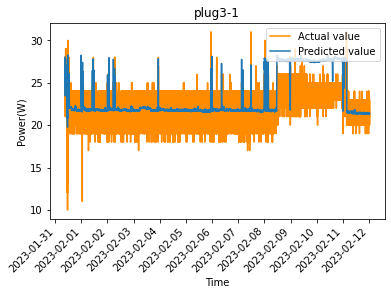

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_test = plug1_1[~np.array(mask1)]
y_test = pd.DataFrame(y_test[:-140])

y_test.index = pd.to_datetime(y_test.index, format='"%Y-%m-%d %H:%M:%S"')

# 將y_test轉換為NumPy陣列
y_test_np = y_test.to_numpy()

# 創建x軸數據
x = mdates.date2num(y_test.index)

# 繪製圖表

fig, ax = plt.subplots(facecolor='white')

ax.plot(x, y_test_np,label="Actual value",color='darkorange')
plt.plot(x,predict_list,label="Predicted value")

# 設置x軸格式
xfmt = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(xfmt)

# 設置x軸間隔為1天(1440分鐘)
xloc = mdates.MinuteLocator(interval=1440)
ax.xaxis.set_major_locator(xloc)

# 旋轉x軸標籤，以避免擠在一起
fig.autofmt_xdate(rotation=45)
# fig.subplots_adjust(right=1)
# 設置標籤
plt.xlabel('Time')
plt.ylabel('Power(W)')
plt.title('plug3-1')
plt.legend(loc='upper right')
plt.savefig('/home/awinlab/Documents/kevin/SGN/FedAvg/SGN_plug3-1.png')
plt.show()

In [ ]:
# y_test_list = y_test.numpy()
# import csv

# with open('/home/awinlab/Documents/kevin/WGRU/FedAvg/WindowGRU110V.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     for i in range(1):
#         writer.writerow([])
#     for row1, row2 in zip(y_test_list[:-120],predict_list.reshape(719880,1)):
#         writer.writerow([row1[0], row2[0]])